# Pneumonia Detection from X-Ray Images

Pneumonia is a potentially life-threatening ["infection that inflames the air sacs in one or both lungs."](https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204#:~:text=Pneumonia%20is%20an%20infection%20that,and%20fungi%2C%20can%20cause%20pneumonia.) "A variety of organisms, including bacteria, viruses and fungi can cause pneumonia." Pneumonia is especially relevant today in the treatment of serious Covid-19 infections. Increasing the detection rate of pneumonia can increase the quality of healthcare in hospitals and clinics around the world, and automated processes can help particularly when hospitals are understaffed or short of funding. One machine learning model could analyze thousands of x-rays per hour, serving clinics across the globe.

In this notebook we'll build a deep-learning model to analyze x-ray images for the presence of Pneumonia. We'll be looking at over 5000 X-rays of children age 1-5 sourced from UCSD, building a few convolutional neural nets to interpret and classify these images. Note that in order for our model to generalize to adults, we would need additional training data, which might be supplemented by the model built in this notebook as pretraining.

We'll use data generation to increase the size of this dataset, helping our model generalize to new images at different angles or sizes. This might make our model take longer to train, but eventually increases performance on unseen data. Resizing images is a balance between model performance and training times. Since all of the training in this notebook was done locally, an image size of 80x80 was chosen to keep training times under 1 hour.

The packages we'll use for this analysis are standard for deep learning, with many keras and tensorflow packages for deep learning and sklearn packages for model evaluation and data preparation. These packages are super deep and give us more than enough to work with for this stage of prototyping.

Our model architecture is iterative, starting with a simple three-layer CNN. We quickly see the limits of this simple system, and have three more iterations of increasing complexity, the second model having 9 layers and dropout, with the third model having ten layers with dropout and a learning rate, and the fourth and final model has eleven layers with dropout and a learning rate. Our final model had an accuracy of 92% on holdout test data, with a particularly nice 95% recall on sick cases. This means only 1 in 20 unhealthy x-rays are missed. This could be further tuned by experimenting with the decision threshold if a higher precision or recall were needed in application.

### Loading Packages

In [1876]:
import re
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics, model_selection, svm
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.applications.resnet import preprocess_input
from keras import layers, models, regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout , BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import SeparableConv2D
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Wide Notebook
# from IPython.display import display, HTML 
# display(HTML("<style>.container { width:100% !important; }</style>"))

We'll also set our randomization seeds now to make our results more reproducible:

In [1507]:
np.random.seed(42)
random.seed(12345)

### Pre-Processing and Inspecting Images
Let's get more familiar with the structure of our data and start to think about how we will interface with these files. The file structure of our database separates data into training, validation, and test sets.

In [1508]:
# Set these file paths to the location of your data (with /*/* wildcards to grab all files)
train_files = tf.io.gfile.glob('data/train/*/*')
val_files = tf.io.gfile.glob('data/val/*/*')
test_files = tf.io.gfile.glob('data/test/*/*')

Let's preview some of the images:

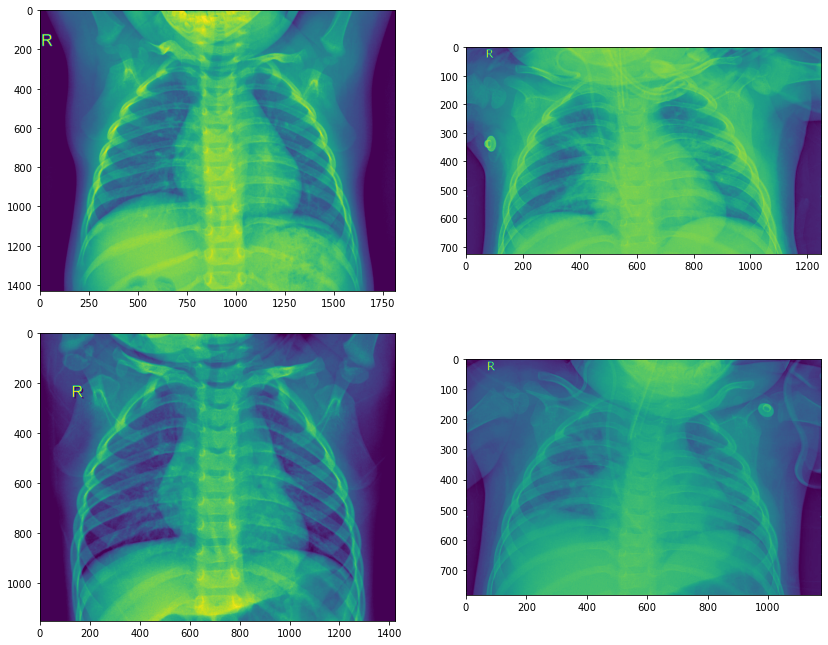

In [1509]:
# Side-by-side preview
c = plt.figure(figsize=(14, 22))

# Normal Pic Previews
c1 = c.add_subplot(1,2,1)
plt.imshow(Image.open(train_files[1]));
c2 = c.add_subplot(2,2,1)
plt.imshow(Image.open(train_files[2]));

# Unhealthy Pic Previews
c3 = c.add_subplot(1,2,2)
plt.imshow(Image.open(train_files[-1]));
c4 = c.add_subplot(2,2,2)
plt.imshow(Image.open(train_files[-2]));

# Uncomment to see labels:
# c1.set_title(train_files[1]);
# c2.set_title(train_files[10]);
# c3.set_title(train_files[-1]);
# c4.set_title(train_files[-2]);

I can't really tell the difference between the healthy and unhealthy pictures; I can see how mistakes could happen here! Maybe our model will perform better than I do? Let's look at the lengths of our filesets.

In [1510]:
# Preview the File Counts
print('Train Files: ', len(train_files))
print('Validation Files: ', len(val_files))
print('Test Files: ', len(test_files))

Train Files:  5216
Validation Files:  16
Test Files:  624


The validation set is unusually small, with only a couple images each. This might throw off our validation metrics, so we'll change this and work with a more traditional 80/20 train/val split.

In [1511]:
# Extend the Training Set with Validation Files
train_files.extend(val_files)
print('Combined Length: ', len(train_files))

# Perform another split into train/validation files
train_files, val_files = train_test_split(train_files, test_size=0.2)
print('New Train Length: ', len(train_files))
print('New Validation Length: ', len(val_files))

Combined Length:  5232
New Train Length:  4185
New Validation Length:  1047


Next, we'll look at the distribution of classes and check if there's a class imbalance we need to be aware of.

In [1512]:
len_normal = len([f for f in train_files if 'NORMAL' in f])
print('Normal lungs:', len_normal)
len_pneumonia = len([f for f in train_files if 'PNEUMONIA' in f])
print('Unhealthy lungs:', len_pneumonia)

Normal lungs: 1059
Unhealthy lungs: 3126


This is a considerable class imbalance, so later we will have to use weights to rebalance the scales. First let's associate labels with the data in a way that can be fed into our deep learning model. Let's create a function to prepare these files and turn them into labeled dataframes.

In [1513]:
# Splitting Function
def label_split(split_file, label):
    label_list = []
    not_label_list = []
    
    for file in split_file: # Splitting file into two lists
        if "PNEUMONIA" in file:
            label_list.append(file)
        else:
            not_label_list.append(file)
            
    return pd.DataFrame(data=label_list).assign(target='sick').append(not_label_list).fillna('healthy').rename(columns={0:'file_path'}) # Creating and organizing dataframe from lists

Now let's use our function on train, validation, and test sets to create three dataframes:

In [1514]:
train = label_split(train_files, "PNEUMONIA") # Train Set
val = label_split(val_files, "PNEUMONIA") # Validation Set
test = label_split(test_files, "PNEUMONIA") # Test Set

In [1626]:
val.head(5)

,file_path,target
0,data\train\PNEUMONIA\person1436_bacteria_3711....,sick
1,data\train\PNEUMONIA\person1048_bacteria_2982....,sick
2,data\train\PNEUMONIA\person1256_bacteria_3214....,sick
3,data\train\PNEUMONIA\person44_bacteria_218.jpeg,sick
4,data\train\PNEUMONIA\person597_virus_1150.jpeg,sick


Now our files will be a little easier to reference and work with. Next we should think about expanding our dataset using data generation. This should help our model generalize, as if it is working with a much larger dataset. It might also help in real-world applications, when x-ray images might be different sizes and rotations.

### Data Generation
Data Generation will help with our class imbalance and help combat overfitting. We will make two different data generators to preserve the validity of the test data. Let's set the parameters here:

In [1516]:
# Parameters
img_size = (100, 100) # The image sizes our data generator will create
SHAPE = (100,100,3) # The image sizes our model will interpret
batch_size = 32

And now our two data generators:

In [1533]:
# Data Generation Block
# Data Generator for Train and Validation Data
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False,
                                   fill_mode='nearest')
# Data generator for test data
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  #Image normalization.

Now we will fit these data generators to our data:

In [1783]:
# Applying the data generation to each dataset
train_set = datagen.flow_from_dataframe(dataframe=train, 
                                      x_col='file_path', 
                                      y_col='target', 
                                      class_mode='binary',
                                      target_size = img_size,
                                      batch_size = batch_size,
#                                       shuffle=False,
                                      seed=42)
val_set = datagen.flow_from_dataframe(dataframe=val, 
                                      x_col='file_path', 
                                      y_col='target', 
                                      class_mode='binary',
                                      target_size = img_size,
                                      batch_size = batch_size,
                                      shuffle=False,
                                      seed=42)
test_set = test_datagen.flow_from_dataframe(dataframe=test, 
                                      x_col='file_path', 
                                      y_col='target', 
                                      class_mode='binary',
                                      target_size = img_size,
                                      batch_size = batch_size,
                                      shuffle=False,
                                      seed=42)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Now our data should be prepared for our first deep learning model!

---
## Designing the First Model
The first thing we'll do is define which metrics we want our models to measure:

In [1784]:
# Establish our metrics
METRICS = ['acc',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

Now let's structure our first baseline model:

In [1785]:
from tensorflow.keras import optimizers

### Building the Model
model_1 = Sequential()

model_1.add(Conv2D(64, (3, 3), activation="relu", input_shape=SHAPE))         # Convolution
model_1.add(MaxPooling2D(pool_size = (2, 2), padding='same'))                 # 1st pooling layer
model_1.add(Conv2D(64, (3, 3), activation="relu", padding='same'))            # 2nd Convolution
model_1.add(MaxPooling2D(pool_size = (2, 2)))                                 # 2nd Pooling layer

model_1.add(Flatten()) # Flatten the layer

model_1.add(Dense(activation = 'relu', units = 128, kernel_regularizer=regularizers.l2(0.004))) # Fully Connected Layer
model_1.add(Dense(activation = 'sigmoid', units = 1)) # Output Layer

# Compile the Neural network
model_1.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = METRICS) # Adam seems to perform the best

# Define the callbacks - this will be used for early stopping to avoid excessively long training times
early_stopping = [EarlyStopping(monitor='val_acc', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', 
                  monitor='val_acc', 
                  save_best_only=True)]

model_1.summary()

Model: "sequential_316"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_250 (Conv2D)         (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d_375 (MaxPooli  (None, 49, 49, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_251 (Conv2D)         (None, 49, 49, 64)        36928     
                                                                 
 max_pooling2d_376 (MaxPooli  (None, 24, 24, 64)       0         
 ng2D)                                                           
                                                                 
 flatten_110 (Flatten)       (None, 36864)             0         
                                                                 
 dense_282 (Dense)           (None, 128)            

Over four million parameters. Let's train the model and see how it performs!

### Training and Evaluating our first model
First let's define some more parameters. These will be unchanging from model to model, as they depend on the data.

In [1786]:
### Parameters
# Steps per epoch
steps_per_epoch = len(train)//batch_size # Steps/epoch, as a fraction of train length
validation_steps = len(test)//batch_size # Steps/epoch, as a fraction of val length

# Class Weights
class_weight = {0: ((1/len_normal)*len(train_files)/2), 1: ((1/len_pneumonia)*len(train_files)/2)} # setting our weights
print(f'Our weights are {class_weight} for healthy and sick, respectively.')

Our weights are {0: 1.9759206798866857, 1: 0.6693857965451055} for healthy and sick, respectively.


Now we'll train our model. This will take some time!

In [1787]:
# ⏰ This cell may take several minutes to run 
start = datetime.datetime.now()
model_1_history = model_1.fit(train_set,
                              steps_per_epoch = steps_per_epoch,
                              epochs = 10,
                              callbacks=early_stopping,
                              validation_data = val_set,
                              validation_steps = validation_steps,
                              class_weight = class_weight,
                              shuffle=False)

end = datetime.datetime.now()
elapsed = end-start
print('Training took a total of {}'.format(elapsed))

Epoch 1/10
130/130 [==============================] - 67s 508ms/step - loss: 8.9291 - acc: 0.5243 - precision: 0.8317 - recall: 0.4549 - val_loss: 1.5467 - val_acc: 0.7188 - val_precision: 1.0000 - val_recall: 0.7188
Epoch 2/10
130/130 [==============================] - 66s 504ms/step - loss: 1.2544 - acc: 0.7865 - precision: 0.9402 - recall: 0.7629 - val_loss: 1.1131 - val_acc: 0.8109 - val_precision: 1.0000 - val_recall: 0.8109
Epoch 3/10
130/130 [==============================] - 66s 504ms/step - loss: 1.0406 - acc: 0.8072 - precision: 0.9465 - recall: 0.7863 - val_loss: 1.0086 - val_acc: 0.7895 - val_precision: 1.0000 - val_recall: 0.7895
Epoch 4/10
130/130 [==============================] - 66s 504ms/step - loss: 0.9134 - acc: 0.8224 - precision: 0.9526 - recall: 0.8019 - val_loss: 0.9133 - val_acc: 0.7928 - val_precision: 1.0000 - val_recall: 0.7928
Epoch 5/10
130/130 [==============================] - 66s 506ms/step - loss: 0.8151 - acc: 0.8389 - precision: 0.9586 - recall: 0.81

That is a fairly solid validation accuracy - it looks like the best epoch performed at ~91%. Let's dig deeper into our results.

### Visualizing Model History
Let's make some functions, as we will visualize every model iteration.

In [1788]:
# Creating a function to show training history
def graph_model_history(model_history):
    f = plt.figure(figsize=(10, 4))
    
    # Accuracy 
    f1 = f.add_subplot(1,2,1)
    f1.plot(model_history.history['acc'])
    f1.plot(model_history.history['val_acc'])
    f1.set_title('Model Accuracy')
#     f1.ylabel('Accuracy')
#     f1.xlabel('Epoch')
    f1.legend(['Training set', 'Validation set'], loc='best')

    # Loss
    f2 = f.add_subplot(1,2,2)
    f2.plot(model_history.history['val_loss'])
    f2.plot(model_history.history['loss'])
    f2.set_title('Model Loss')
#     f2.ylabel('Loss')
#     f2.xlabel('Epoch')
    f2.legend(['Training set', 'Validation set'], loc='upper left')

In [1794]:
# Creating a classification report function
def get_class_report(model):
    y_true = val_set.classes
    predictions = model.predict(val_set)
    y_pred = []
    for sublist in list(predictions.round().astype(int).tolist()):
        for item in sublist:
            y_pred.append(item)
#     print(f'P labels: {y_pred}')
#     print(f'T labels: {y_true}')
    print(classification_report(y_true, y_pred, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

In [1790]:
# Creating a validation set accuracy measure
def get_acc(model):
    accu = model.evaluate_generator(val_set, steps=20)
#     accu = model.evaluate(val_set, y_val, steps=20)
    print('The validation accuracy is :', accu[1]*100, '%')

Now let's use our validation functions to understand our model training.

33/33 [==============================] - 13s 380ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.71      0.90      0.79       290
Pneumonia (Class 1)       0.96      0.86      0.91       757

           accuracy                           0.87      1047
          macro avg       0.83      0.88      0.85      1047
       weighted avg       0.89      0.87      0.88      1047



C:\Users\8D\AppData\Local\Temp/ipykernel_18424/2481722222.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accu = model.evaluate_generator(val_set, steps=20)


The validation accuracy is : 87.0312511920929 %


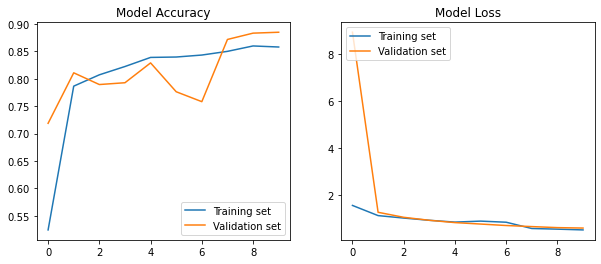

In [1795]:
graph_model_history(model_1_history)
get_class_report(model_1)
get_acc(model_1)

Interesting - these look like fairly reasonable training curves, with maybe a bit of overfitting towards the end. Our validation accuracy is serviceable. Let's see if we can improve upon this baseline with more iterations.

---
## Model Iterations
### Model 2
At this stage our models are going to keep getting more complex - to simplify our code, let's create some functions to modularize things. These are inspired by existing workflows and practices shown [in this article](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8) and [notebook](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays)

In [1081]:
# A block for convolution, batch normalization, and pooling
# I'm not sure why there are two conv2d layers in this conv_block, but it does tend to improve performance in testing
def conv_block(neurons):
    conv = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(neurons, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(neurons, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()])
    return conv

# A block for densely connected layers with normalization and dropout
def dense_block(neurons, dropout_rate):
    dense = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)])
    return dense

Now we can use these functions to quickly create clean, interpretable models:

In [1759]:
### Building a second Model
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=SHAPE), # Defining input shape
    conv_block(16), tf.keras.layers.Dropout(0.2),
    conv_block(32), tf.keras.layers.Dropout(0.2),
    conv_block(64), tf.keras.layers.Dropout(0.2),
    conv_block(64), tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    
    dense_block(64, 0.3),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the Neural network
model_2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = METRICS) # 'adam'

Now if we need to change the patience, here is our callback block:

In [1760]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_acc', 
                                patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', 
                  monitor='val_acc', 
                  save_best_only=True)]

Now we can train model 2 and see how our more complex model performs:

In [1792]:
# ⏰ This cell may take several minutes to run 
start = datetime.datetime.now()
model_2_history = model_2.fit_generator(train_set,
                              steps_per_epoch = steps_per_epoch,
                              epochs = 20,
                              callbacks=early_stopping,
                              validation_data = val_set,
                              validation_steps = validation_steps,
                              class_weight = class_weight,
                              shuffle=False)

end = datetime.datetime.now()
elapsed = end-start
print('Training took a total of {}'.format(elapsed))

C:\Users\8D\AppData\Local\Temp/ipykernel_18424/1900323647.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_2_history = model_2.fit_generator(train_set,


Epoch 1/20
130/130 [==============================] - 60s 459ms/step - loss: 0.1716 - acc: 0.9337 - precision: 0.9806 - recall: 0.9295 - val_loss: 0.3767 - val_acc: 0.8438 - val_precision: 1.0000 - val_recall: 0.8438
Epoch 2/20
130/130 [==============================] - 62s 478ms/step - loss: 0.1681 - acc: 0.9322 - precision: 0.9803 - recall: 0.9280 - val_loss: 0.2380 - val_acc: 0.9178 - val_precision: 1.0000 - val_recall: 0.9178
Epoch 3/20
130/130 [==============================] - 61s 472ms/step - loss: 0.1668 - acc: 0.9346 - precision: 0.9797 - recall: 0.9317 - val_loss: 0.2587 - val_acc: 0.8816 - val_precision: 1.0000 - val_recall: 0.8816
Epoch 4/20
130/130 [==============================] - 64s 491ms/step - loss: 0.1627 - acc: 0.9365 - precision: 0.9820 - recall: 0.9322 - val_loss: 0.1056 - val_acc: 0.9556 - val_precision: 1.0000 - val_recall: 0.9556
Epoch 5/20
130/130 [==============================] - 62s 478ms/step - loss: 0.1501 - acc: 0.9387 - precision: 0.9818 - recall: 0.93

Hmm, this is looking better! We may still be overfitting, or our learning rate is too high? Let's look at our training history:

33/33 [==============================] - 12s 370ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.89      0.96      0.92       290
Pneumonia (Class 1)       0.98      0.95      0.97       757

           accuracy                           0.96      1047
          macro avg       0.94      0.96      0.95      1047
       weighted avg       0.96      0.96      0.96      1047



C:\Users\8D\AppData\Local\Temp/ipykernel_18424/2481722222.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accu = model.evaluate_generator(val_set, steps=20)


The validation accuracy is : 95.15625238418579 %


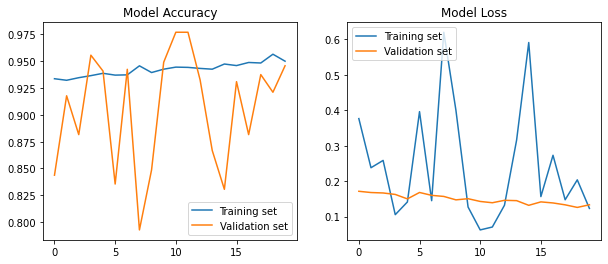

In [1796]:
graph_model_history(model_2_history)
get_class_report(model_2)
get_acc(model_2)

The validation performance is really bouncing around - Let's add a learning rate and see if that helps.

---
### Model 3

In [1800]:
# Establishing learnign rate
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [1801]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_acc', 
                                patience=20), 
                  ModelCheckpoint(filepath='best_model.h5', 
                  monitor='val_acc', 
                  save_best_only=True)]

Our third model is similar to our second, but we are going to try adding more pooling layers, increasing the neurons in our convolutional blocks, and adding another dense layer. All of this will tend to increase our model complexity.

In [1802]:
### Building a third Model
model_3 = tf.keras.Sequential([
    tf.keras.Input(shape=SHAPE),
    
    conv_block(16),  tf.keras.layers.Dropout(0.2), # Convolutional and pooling block with 32 neurons & dropout
    conv_block(32),  tf.keras.layers.Dropout(0.2), # Convolutional and pooling block with 32 neurons & dropout
    conv_block(64),  tf.keras.layers.Dropout(0.2), # Convolutional and pooling block with 32 neurons & dropout
    conv_block(64),  tf.keras.layers.Dropout(0.2), # Convolutional and pooling block with 64 neurons & dropout
    
    tf.keras.layers.Flatten(),
    dense_block(32, 0.3),   # Dense layer with dropout
    dense_block(64, 0.2),   # Dense layer with dropout
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the Neural network
model_3.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = METRICS) # 'adam'

# model_3.summary()

Now we should be ready to fit our model:

In [1803]:
# ⏰ This cell may take several minutes to run 
start = datetime.datetime.now()
model_3_history = model_3.fit_generator(train_set,
                              steps_per_epoch = steps_per_epoch,
                              epochs = 30,
                              callbacks=[early_stopping, lr_scheduler],
                              validation_data = val_set,
                              validation_steps = validation_steps,
                              class_weight = class_weight)

end = datetime.datetime.now()
elapsed = end-start
print('Training took a total of {}'.format(elapsed))

C:\Users\8D\AppData\Local\Temp/ipykernel_18424/394226405.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_3_history = model_3.fit_generator(train_set,


Epoch 1/30
130/130 [==============================] - 65s 487ms/step - loss: 0.4205 - acc: 0.7958 - precision: 0.9542 - recall: 0.7893 - val_loss: 0.0163 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/30
130/130 [==============================] - 62s 476ms/step - loss: 0.3130 - acc: 0.8654 - precision: 0.9605 - recall: 0.8549 - val_loss: 0.0632 - val_acc: 0.9918 - val_precision: 1.0000 - val_recall: 0.9918 - lr: 0.0089
Epoch 3/30
130/130 [==============================] - 62s 477ms/step - loss: 0.2799 - acc: 0.8851 - precision: 0.9676 - recall: 0.8757 - val_loss: 2.2388 - val_acc: 0.4013 - val_precision: 1.0000 - val_recall: 0.4013 - lr: 0.0079
Epoch 4/30
130/130 [==============================] - 61s 471ms/step - loss: 0.2639 - acc: 0.8876 - precision: 0.9711 - recall: 0.8756 - val_loss: 2.7050 - val_acc: 0.2401 - val_precision: 1.0000 - val_recall: 0.2401 - lr: 0.0071
Epoch 5/30
130/130 [==============================] - 62s 477ms/step - loss: 0.2

33/33 [==============================] - 13s 390ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.84      0.97      0.90       290
Pneumonia (Class 1)       0.99      0.93      0.96       757

           accuracy                           0.94      1047
          macro avg       0.91      0.95      0.93      1047
       weighted avg       0.95      0.94      0.94      1047



C:\Users\8D\AppData\Local\Temp/ipykernel_18424/2481722222.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accu = model.evaluate_generator(val_set, steps=20)


The validation accuracy is : 92.5000011920929 %


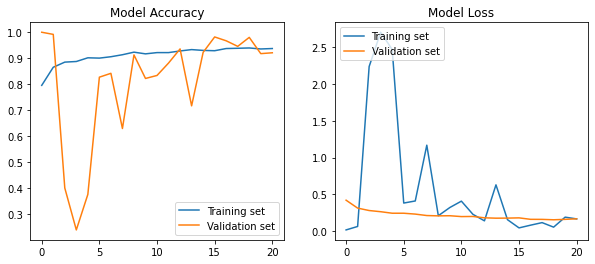

In [1804]:
graph_model_history(model_3_history)
get_class_report(model_3)
get_acc(model_3)

That might be better performing on test data, but it's hard to say. Let's try one more iteration

---
### Model 4
This fourth model has some additional cnn layers, and makes consistent use of dropout. 

In [1768]:
### Building a fourth Model
model_4 = tf.keras.Sequential([
    tf.keras.Input(shape=SHAPE),
    
    conv_block(32),  tf.keras.layers.Dropout(0.1),  # Convolutional and pooling block with 32 neurons & dropout
    conv_block(64),  tf.keras.layers.Dropout(0.1),  # Convolutional and pooling block with 32 neurons & dropout
    conv_block(64),  tf.keras.layers.Dropout(0.2),  # Convolutional and pooling block with 32 neurons & dropout
    conv_block(128),  tf.keras.layers.Dropout(0.2), # Convolutional and pooling block with 64 neurons & dropout
    conv_block(256),  tf.keras.layers.Dropout(0.2), # Convolutional and pooling block with 64 neurons & dropout

    
    tf.keras.layers.Flatten(),
    dense_block(128, 0.2),   # Dense layer with dropout
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the Neural network
model_4.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = METRICS) # 'adam'

# model_4.summary()

In [1806]:
# ⏰ This cell may take several minutes to run 
start = datetime.datetime.now()
model_4_history = model_4.fit_generator(train_set,
                              steps_per_epoch = steps_per_epoch,
                              epochs = 30,
                              callbacks=[early_stopping, lr_scheduler],
                              validation_data = val_set,
                              validation_steps = validation_steps,
                              class_weight = class_weight)

end = datetime.datetime.now()
elapsed = end-start
print('Training took a total of {}'.format(elapsed))

C:\Users\8D\AppData\Local\Temp/ipykernel_18424/2751785311.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_4_history = model_4.fit_generator(train_set,


Epoch 1/30
130/130 [==============================] - 71s 544ms/step - loss: 0.3087 - acc: 0.8652 - precision: 0.9584 - recall: 0.8563 - val_loss: 6.0989 - val_acc: 0.2664 - val_precision: 1.0000 - val_recall: 0.2664 - lr: 0.0100
Epoch 2/30
130/130 [==============================] - 71s 545ms/step - loss: 0.2349 - acc: 0.9046 - precision: 0.9711 - recall: 0.8990 - val_loss: 1.3551 - val_acc: 0.5822 - val_precision: 1.0000 - val_recall: 0.5822 - lr: 0.0089
Epoch 3/30
130/130 [==============================] - 71s 542ms/step - loss: 0.2128 - acc: 0.9143 - precision: 0.9744 - recall: 0.9090 - val_loss: 0.1456 - val_acc: 0.9507 - val_precision: 1.0000 - val_recall: 0.9507 - lr: 0.0079
Epoch 4/30
130/130 [==============================] - 71s 545ms/step - loss: 0.1872 - acc: 0.9309 - precision: 0.9763 - recall: 0.9301 - val_loss: 0.2504 - val_acc: 0.8964 - val_precision: 1.0000 - val_recall: 0.8964 - lr: 0.0071
Epoch 5/30
130/130 [==============================] - 71s 544ms/step - loss: 0.1

33/33 [==============================] - 13s 396ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.93      0.97      0.95       290
Pneumonia (Class 1)       0.99      0.97      0.98       757

           accuracy                           0.97      1047
          macro avg       0.96      0.97      0.96      1047
       weighted avg       0.97      0.97      0.97      1047



C:\Users\8D\AppData\Local\Temp/ipykernel_18424/2481722222.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accu = model.evaluate_generator(val_set, steps=20)


The validation accuracy is : 96.24999761581421 %


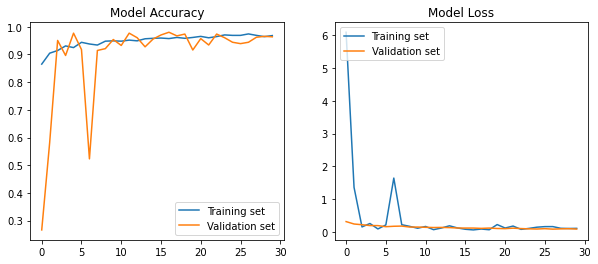

In [1807]:
graph_model_history(model_4_history)
get_class_report(model_4)
get_acc(model_4)

Okay, that's looking great :-) our f1, precision and recall are all excellent.

## Model Comparison and Visualization
Let's see these three models side-by-side, and choose the best model to deploy.

In [1879]:
# model_1.summary()
# model_2.summary()
# model_3.summary()
# model_4.summary()

In [1822]:
print("Validation accuracy of model 1 is - " , model_1.evaluate(val_set)[1]*100 , "%")
print("Validation accuracy of model 2 is - " , model_2.evaluate(val_set)[1]*100 , "%")
print("Validation accuracy of model 3 is - " , model_3.evaluate(val_set)[1]*100 , "%")
print("Validation accuracy of model 4 is - " , model_4.evaluate(val_set)[1]*100 , "%")

33/33 [==============================] - 12s 366ms/step - loss: 0.5346 - acc: 0.8835 - precision: 0.9649 - recall: 0.8705
Accuracy of model 1 is -  88.34766149520874 %
33/33 [==============================] - 12s 368ms/step - loss: 0.1325 - acc: 0.9532 - precision: 0.9876 - recall: 0.9472
Accuracy of model 2 is -  95.31996250152588 %
33/33 [==============================] - 12s 361ms/step - loss: 0.1309 - acc: 0.9475 - precision: 0.9902 - recall: 0.9366
Accuracy of model 3 is -  94.74689364433289 %
33/33 [==============================] - 12s 379ms/step - loss: 0.0935 - acc: 0.9685 - precision: 0.9892 - recall: 0.9670
Accuracy of model 4 is -  96.84813618659973 %


Model 4 had the best Validation accuracy. Let's look at the class reports and think in terms of precision, recall, and f1:

In [1870]:
print('Model 1 Classification Report:')
get_class_report(model_1)
print('Model 2 Classification Report:')
get_class_report(model_2)
print('Model 3 Classification Report:')
get_class_report(model_3)
print('Model 4 Classification Report:')
get_class_report(model_4)

Model 1 Classification Report:
33/33 [==============================] - 13s 380ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.73      0.88      0.80       290
Pneumonia (Class 1)       0.95      0.87      0.91       757

           accuracy                           0.88      1047
          macro avg       0.84      0.88      0.85      1047
       weighted avg       0.89      0.88      0.88      1047

Model 2 Classification Report:
33/33 [==============================] - 12s 369ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.88      0.94      0.91       290
Pneumonia (Class 1)       0.98      0.95      0.96       757

           accuracy                           0.95      1047
          macro avg       0.93      0.95      0.94      1047
       weighted avg       0.95      0.95      0.95      1047

Model 3 Classification Report:
33/33 [==============================] - 13s 381ms/step
 

Again it's looking like model_4 is our star. Let's go ahead and test it on holdout data!

## Final Model Selection
We'll go ahead and make our test evaluation a big function which makes a classification report, confusion matrix, and ROC curve:

In [1873]:
from sklearn.metrics import accuracy_score, confusion_matrix

def test_eval(model):
    
    print("Overall, our accuracy on unseen test data can be understood by the following: \n")
    
    # Classification Report
    y_test = test_set.classes
    test_predictions = model.predict(test_set)
    y_test_pred = []
    for sublist in list(test_predictions.round().astype(int).tolist()):
        for item in sublist:
            y_test_pred.append(item)
    print(classification_report(y_test, y_test_pred, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
    
    # Confusion Matrix
    acc = accuracy_score(y_test, y_test_pred)*100
    cm = confusion_matrix(y_test, np.round(y_test_pred))
    tn, fp, fn, tp = cm.ravel()
    cm = confusion_matrix(y_test, y_test_pred)
    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
    plt.figure(figsize = (10,10))
    sns.heatmap(cm,cmap= "Blues", annot = True, fmt='',xticklabels = labels,yticklabels = labels);
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predictions)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

Overall, our accuracy on unseen test data can be understood by the following: 

20/20 [==============================] - 6s 304ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.91      0.87      0.89       234
Pneumonia (Class 1)       0.92      0.95      0.94       390

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



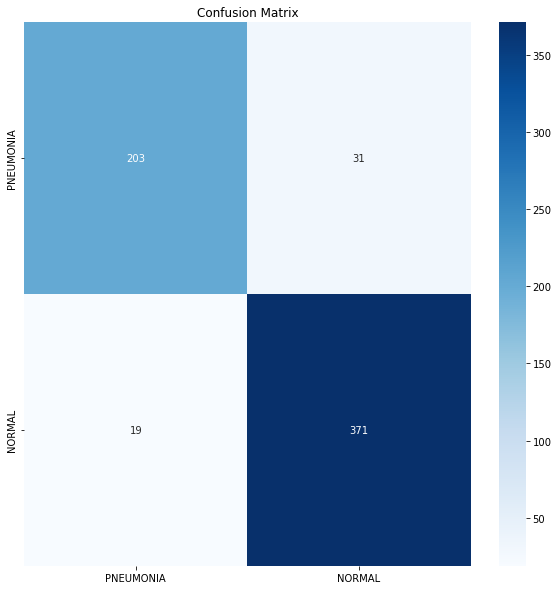

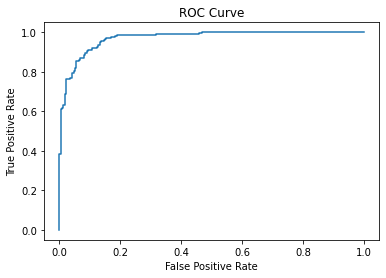

In [1874]:
test_eval(model_4)

I feel this is a great result, particularly because our class imbalance has flipped from the test data; we now have more normal cases than ill cases.

# Conclusions

In this analysis we saw that our convolutional neural network model could create predictions on X-rays with 92% accuracy on unseen images. We chose our fourth model as our final, as it seems to have performed the best on every measure. Given this performance, it absolutely seems that deep learning can provide value in medical diagnosis - more images could be inspected for less expense and workload, or other types of images could be inspected and categorized at scale.

### Next Steps
Process Integratioe > 
Talking to target users and support them with a simple UI, or build a centralized image processing service by taking in images from many medical facilities

Improve model performance > 
It’s likely that these models can continue to be improved with more computation and X-Ray Images

More X-Ray Machine Learnine > 
Can broken bones be identified? What about tumors or cancers? What do doctors need help with? Maybe machine learning can help.



For questions or more data analytics work, I can be contacted through my github at https://github.com/thegrandblooms or through linkedin at www.linkedin.com/in/blake-mcmeekin-14246b183